In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, uniform

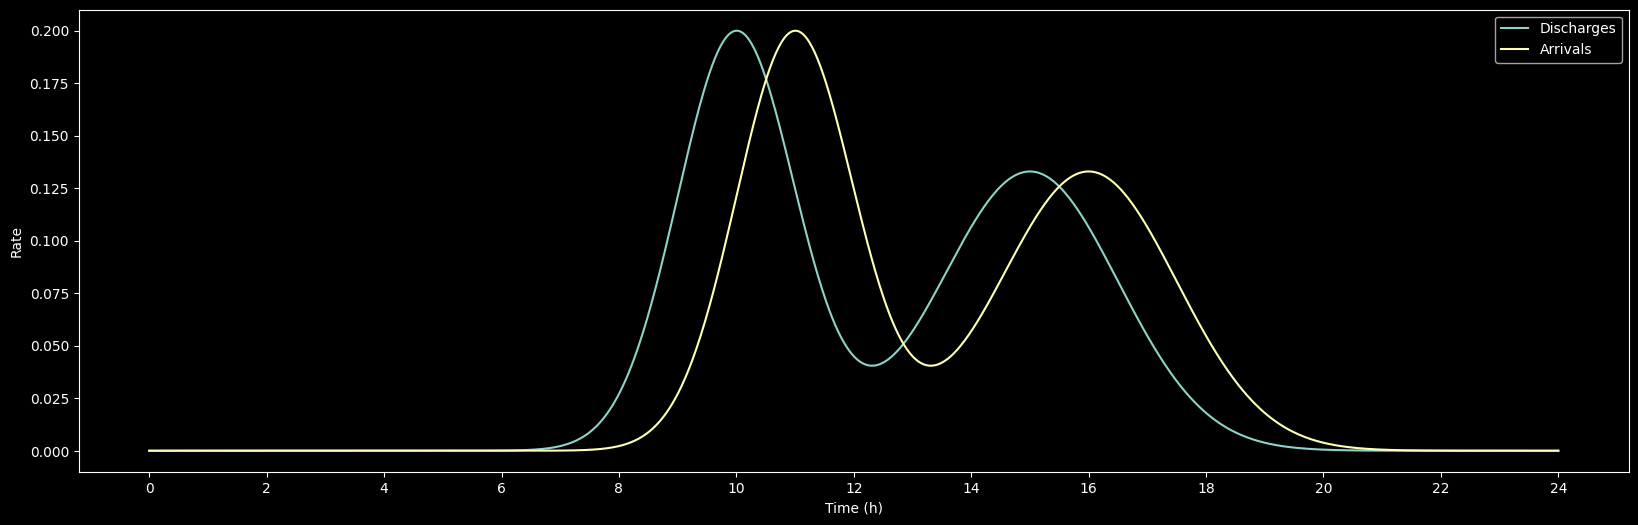

In [12]:
p_ = 0.55
t_ = np.linspace(0, 24, 1000)

class ArrivalDistribution:
    first_round_time = 9
    second_round_time = 15
    def __init__(self, p=0.5, offset=0):
        self.p = p
        self.first_peak = norm(loc=10 + offset, scale=1)
        self.second_peak = norm(loc=15 + offset, scale=1.5)

    def pdf(self, x):
        return self.p * self.first_peak.pdf(x) + (1 - self.p) * self.second_peak.pdf(x)

    def rvs(self, size=()):
        s1 = self.first_peak.rvs(size=size)
        s2 = self.second_peak.rvs(size=size)
        choice = uniform.rvs(size=size) < self.p
        return np.where(choice, s1, s2)

discharge_dist = ArrivalDistribution()
admission_dist = ArrivalDistribution(offset=1)


fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.plot(t_, discharge_dist.pdf(t_), label="Discharges")
ax.plot(t_, admission_dist.pdf(t_), label="Arrivals")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Rate")
ax.set_xticks(np.arange(0, 25, 2), np.arange(0, 25, 2))
ax.legend()
plt.show()

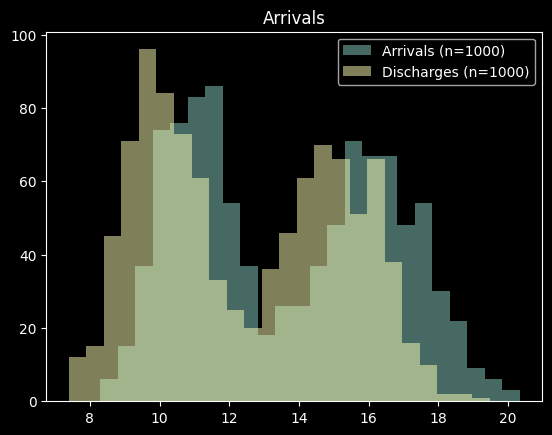

In [13]:
arrivals = admission_dist.rvs(size=1000)
discharges = discharge_dist.rvs(size=1000)

plt.title("Arrivals")
plt.hist(arrivals, alpha=0.5, bins=24, label=f"Arrivals (n={len(arrivals)})")
plt.hist(discharges, alpha=0.5, bins=24, label=f"Discharges (n={len(discharges)})")
plt.legend()
plt.show()

In [14]:
from heapq import heapify, heappop, heappush
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tqdm import tqdm

## Timeline of a bed
All the while the bed may have to wait for available transport and washing. 
- Patient is admitted to the hospital and occupies a bed.
- Patient is discharged, and the bed is sent to the logistics floor.
- Bed is transported from the elevator to the washing area.
- Bed is washed.
- Bed is transported back to the elevator.

In [15]:
from datetime import timedelta
from enum import IntEnum

class Buffer(IntEnum):
    DIRTY = 0
    CLEAN = 1

def decorate_event(cls):
    return dataclass(slots=True, frozen=True)(cls)

@decorate_event
class Event:
    time: float

    def __lt__(self, other):
        return self.time < other.time
    
    # __repr__ didnt work
    def print(self):
        total_seconds = int(self.time * 3600)
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"[{hours:02}:{minutes:02}:{seconds:02}] {self}")


@decorate_event
class PatientArrived(Event):
    pass


@decorate_event
class PatientDischarged(Event):
    pass


@decorate_event
class BedArrivedElevator(Event):
    elevator_id: int
    buffer: Buffer

@decorate_event
class BedArrivedWashing(Event):
    pass

@decorate_event
class BedStartedWashing(Event):
    pass

@decorate_event
class BedFinishedWashing(Event):
    pass

@decorate_event
class RobotsUpdated(Event):
    pass

@decorate_event
class PickUpBed(Event):
    robot_id: int
    location_id: int
    buffer: Buffer

@decorate_event
class DropOffBed(Event):
    robot_id: int
    location_id: int
    buffer: Buffer


In [49]:
def simulate_system(
        discharge_dist : callable,
        arrival_dist: callable,
        service_time_dist : callable,
        transport_time_dist : callable,
        distance_matrix: np.ndarray,
        n_patients: int = 200,

    ):

    # 0 = washer
    # 1 = elevator 1
    # 2 = elevator 2
    # ...
    n_elevators = 1
    n_robots = 2
    robot_speed = 1.4

    buffers = np.zeros((2, 1 + n_elevators))
    reserved = np.zeros_like(buffers)
    demand = np.zeros(1 + n_elevators) # index 0 never used, but keeps indexing consistent

    mean_time = distances / robot_speed

    robot_location = np.zeros(n_robots)
    robot_traveling = np.zeros(n_robots, dtype=bool)
    robot_beds = np.zeros(n_robots, dtype=bool)

    arrival_weights = np.ones(n_elevators) / n_elevators
    discharge_weights = np.ones(n_elevators) / n_elevators

    discharge_times = discharge_dist.rvs(size=n_patients)
    arrival_times = arrival_dist.rvs(size=n_patients)

    events = [PatientDischarged(time) for time in discharge_times]
    events += [PatientArrived(time) for time in arrival_times]
    heapify(events)

    events_processed = []
    buffer_list = [buffers.copy()]
    demand_list = [demand.copy()]
    times = [0.0]

    washer_ready = True

    iterations = 0
    while events:
        iterations += 1
        if iterations > 10000:
            break

        event = heappop(events)
        event.print()

        match event:
            case PatientArrived(time=t):
                eid = np.random.choice(n_elevators, p=arrival_weights) + 1
                if buffers[Buffer.CLEAN, eid] > 0:
                    buffers[Buffer.CLEAN, eid] -= 1
                else:
                    demand[eid] += 1

            case PatientDischarged(time=t):
                eid = np.random.choice(n_elevators, p=discharge_weights) + 1
                heappush(events, BedArrivedElevator(t, eid, Buffer.DIRTY))
            
            case BedArrivedElevator(time=t, elevator_id=eid, buffer=buffer):
                buffers[buffer, eid] += 1
                heappush(events, RobotsUpdated(t))
        
            case BedArrivedWashing(time=t):
                # If washer ready, start washing immediately 
                if washer_ready:
                    heappush(events, BedStartedWashing(t))
                
            case BedStartedWashing(time=t):
                buffers[Buffer.DIRTY, 0] -= 1
                washer_ready = False
                heappush(events, BedFinishedWashing(t + service_time_dist()))

            case BedFinishedWashing(time=t):
                buffers[Buffer.CLEAN, 0] += 1

                heappush(events, RobotsUpdated(t))

                washer_ready = True

                # If washer is ready and there are beds waiting outside
                if buffers[Buffer.DIRTY, 0] > 0:
                    heappush(events, BedStartedWashing(t))
                
            
            case RobotsUpdated(time=t):
                available_robots = np.where(~robot_traveling)[0]
                for robot_id in available_robots:
                    dispatched = False
                    available_beds = buffers - reserved
                    # handle dirty beds first
                    if np.any(available_beds[Buffer.DIRTY, 1:] != 0):
                        location_id = np.argmax(available_beds[Buffer.DIRTY, 1:]) + 1
                        robot_traveling[robot_id] = True

                        reserved[Buffer.DIRTY, location_id] += 1

                        #TODO: make dependent on distance
                        transport_time = transport_time_dist()
                        heappush(events, PickUpBed(t + transport_time, robot_id, location_id, Buffer.DIRTY))    
                        dispatched = True

                    if not dispatched and available_beds[Buffer.CLEAN, 0] != 0:
                        location_id = 0
                        robot_traveling[robot_id] = True

                        reserved[Buffer.CLEAN, location_id] += 1

                        transport_time = transport_time_dist()
                        heappush(events, PickUpBed(t + transport_time, robot_id, location_id, Buffer.CLEAN))
                    #print(robot_location)
                    #print(buffers)

            case PickUpBed(time=t, robot_id=robid, location_id=locid, buffer=buffer):
                assert buffers[buffer, locid] > 0, "Must have beds to pick up!"
                buffers[buffer, locid] -= 1
                reserved[buffer, locid] -= 1
                robot_location[robid] = locid
                robot_beds[robid] = True

                if buffer == Buffer.DIRTY:
                    target_location = 0
                else:
                    expected_time_to_depletion = buffers[Buffer.CLEAN, 1:] / arrival_weights
                    min_time = np.min(expected_time_to_depletion)

                    indices = np.where(expected_time_to_depletion == min_time)[0]
                    target_location = np.random.choice(indices) + 1

                transport_time = transport_time_dist()

                heappush(events, DropOffBed(t + transport_time, robid, target_location, buffer))

            case DropOffBed(time=t, robot_id=robid, location_id=locid, buffer=buffer):
                assert robot_beds[robid], "Robots must have bed to drop off"
                
                buffers[buffer, locid] += 1
                robot_location[robid] = locid
                robot_beds[robid] = False
                robot_traveling[robid] = False

                if locid == 0: # dropped off at washer
                    heappush(events, BedArrivedWashing(t))
                else: # dropped off at elevator
                    if demand[locid] > 0:
                        buffers[buffer, locid] -= 1
                        demand[locid] -= 1

                heappush(events, RobotsUpdated(t))

            case _:
                raise ValueError("Unknown event type!")

        buffer_list.append(buffers.copy())
        demand_list.append(demand.copy())
        times.append(event.time)

        verbose = True
        if verbose:
            print("Buffers")
            print(buffers)
            print("Demand")
            print(demand)
            print("Robots")
            print(robot_location)
            print(robot_traveling)   
            print()         

        events_processed.append(event)

    return events_processed, np.stack(buffer_list, axis=-1), np.stack(demand_list, axis=-1), np.array(times)

np.random.seed(42069)
service_min_time = 5/60
service_time_dist = lambda: service_min_time + expon(scale=1e-10).rvs()
transport_time_dist = lambda: norm(loc=(175/1.4)/(60 * 60), scale=1e-2).rvs()

distances = np.array([
    [0, 175],
    [175, 0],
])

events, buffers, demands, times = simulate_system(discharge_dist, discharge_dist, service_time_dist, transport_time_dist, distances, n_patients=50)

[07:56:28] PatientDischarged(time=np.float64(7.94118270105707))
Buffers
[[0. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0. 0.]
[False False]

[07:56:28] BedArrivedElevator(time=np.float64(7.94118270105707), elevator_id=1, buffer=<Buffer.DIRTY: 0>)
Buffers
[[0. 1.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0. 0.]
[False False]

[07:56:28] RobotsUpdated(time=np.float64(7.94118270105707))
Buffers
[[0. 1.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0. 0.]
[ True False]

[07:59:06] PickUpBed(time=np.float64(7.9850793915480445), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
Buffers
[[0. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[1. 0.]
[ True False]

[08:00:48] DropOffBed(time=np.float64(8.013493900346718), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
Buffers
[[1. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0. 0.]
[False False]

[08:00:48] BedArrivedWashing(time=np.float64(8.013493900346718))
Buffers
[[1. 0.]
 [0. 0.]]
Demand
[0. 0.]
Robots
[0. 0.]
[False False]

[08:00:48] RobotsUpda

In [45]:
for e in events:
    if hasattr(e, "robot_id"):
        e.print()

[07:59:06] PickUpBed(time=np.float64(7.9850793915480445), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[08:00:48] DropOffBed(time=np.float64(8.013493900346718), robot_id=np.int64(0), location_id=0, buffer=<Buffer.DIRTY: 0>)
[08:07:23] PickUpBed(time=np.float64(8.123209923772457), robot_id=np.int64(0), location_id=0, buffer=<Buffer.CLEAN: 1>)
[08:08:26] PickUpBed(time=np.float64(8.140668044548553), robot_id=np.int64(1), location_id=np.int64(1), buffer=<Buffer.DIRTY: 0>)
[08:09:14] DropOffBed(time=np.float64(8.154001320290813), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.CLEAN: 1>)
[08:10:45] DropOffBed(time=np.float64(8.179171084007086), robot_id=np.int64(1), location_id=0, buffer=<Buffer.DIRTY: 0>)
[08:17:47] PickUpBed(time=np.float64(8.296536671599679), robot_id=np.int64(0), location_id=0, buffer=<Buffer.CLEAN: 1>)
[08:18:12] DropOffBed(time=np.float64(8.303384588097389), robot_id=np.int64(0), location_id=np.int64(1), buffer=<Buffer.CLEAN:

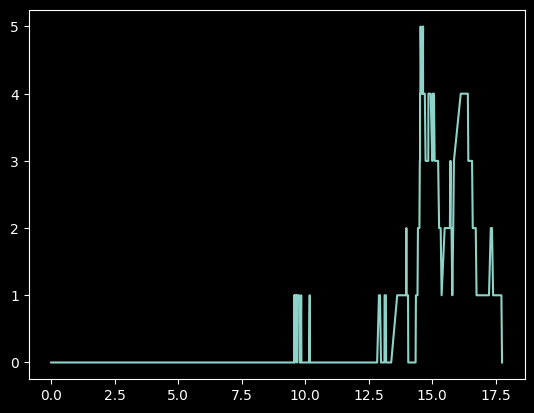

In [51]:
plt.plot(times, demands[1])

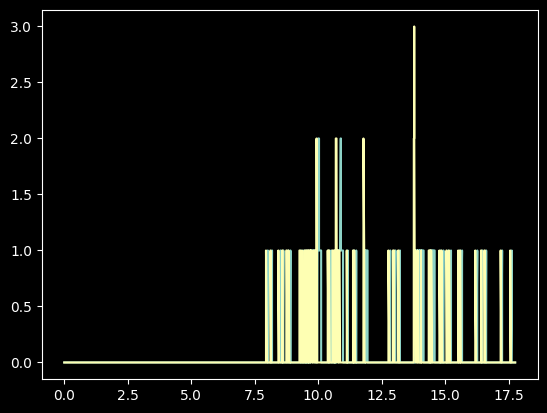

In [53]:
for buffer in buffers[Buffer.DIRTY]:
    plt.plot(times, buffer)

# Looking at distributions

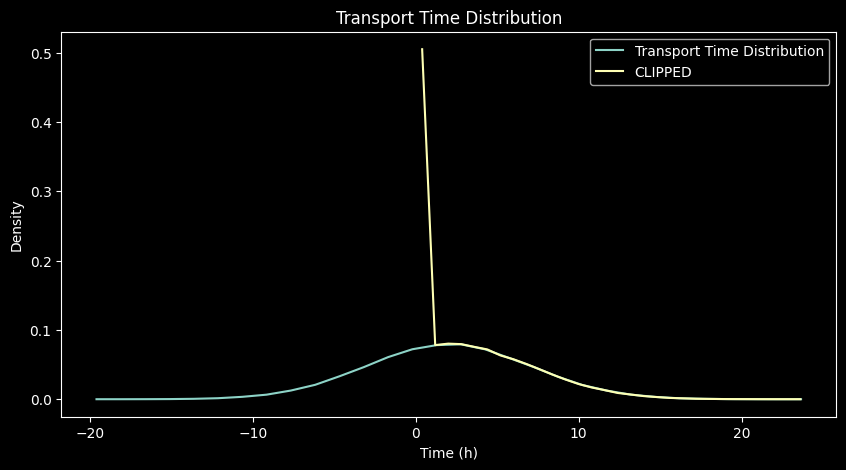

In [18]:
# plot transport_time_dist
def plot_transport_time_dist():
    # sample 100 samples
    samples = norm(loc=2, scale=5).rvs(size=113000)
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    # Center the bins for plotting
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    samples = np.clip(samples, 0, 24)  # Clip to 24 hours
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.plot(t, y, label="CLIPPED")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()

124.00000000000001
124.10722756451115 133.38903130519842 125.13387827965883


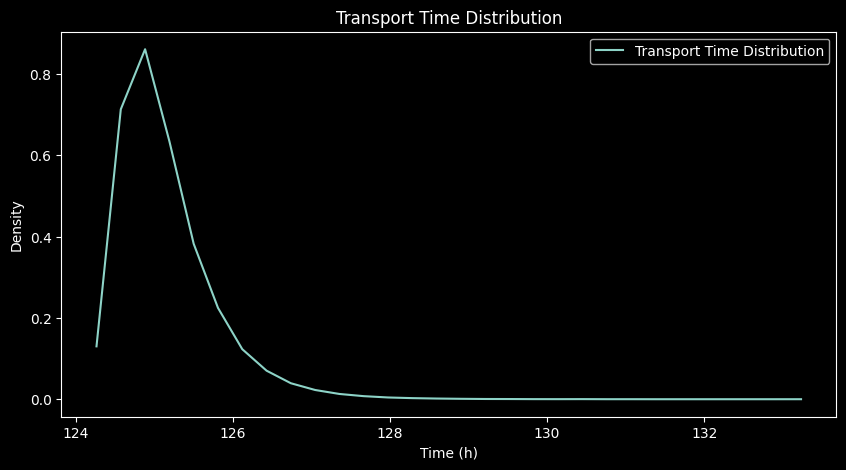

In [19]:
from scipy.stats import lognorm
def plot_transport_time_dist():
    # 175 [m] / 1.4 [m/s]
    loc = (175 / 1.4 - 1)
    print(loc)
    # sample 100 samples
    samples = lognorm(loc=loc, s=.5).rvs(size=100000)# / 60 / 60
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist() # 125.13387827965883

1.0000364749224109 5.479084251025757 1.7987631225633336


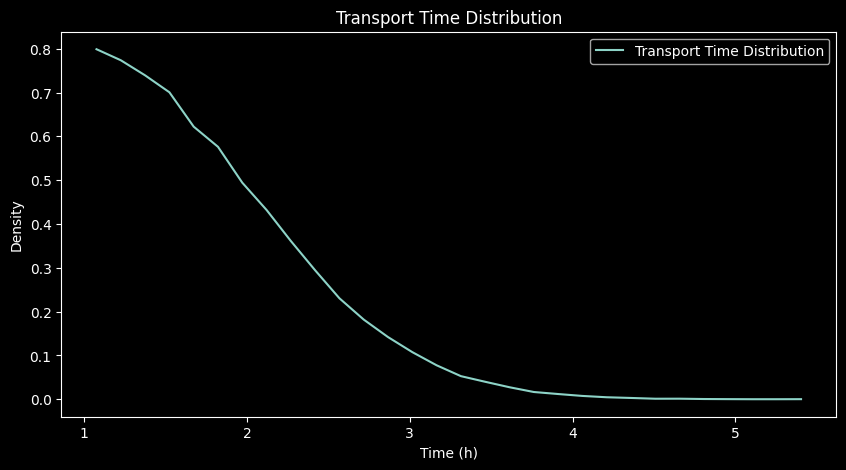

In [20]:
from scipy.stats import halfnorm
def plot_transport_time_dist():
    # sample 100 samples
    samples = halfnorm(loc=1, scale=1).rvs(size=100000)
    print(np.min(samples), np.max(samples), np.mean(samples))
    y, t = np.histogram(samples, bins=30, density=True)
    t = (t[:-1] + t[1:]) / 2  #
    plt.figure(figsize=(10, 5))
    plt.plot(t, y, label="Transport Time Distribution")
    plt.xlabel("Time (h)")
    plt.ylabel("Density")
    plt.title("Transport Time Distribution")
    plt.legend()
    plt.show()
np.random.seed(42)
plot_transport_time_dist()